<a href="https://colab.research.google.com/github/PCBZ/CS6140/blob/main/HW3/HW3_Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Summary:

Shared Covariance:
Mean train accuracy: 0.8900
Mean test accuracy: 0.8872
Seperate Covariance:
Mean train accuracy: 0.8326
Mean test accuracy: 0.8298


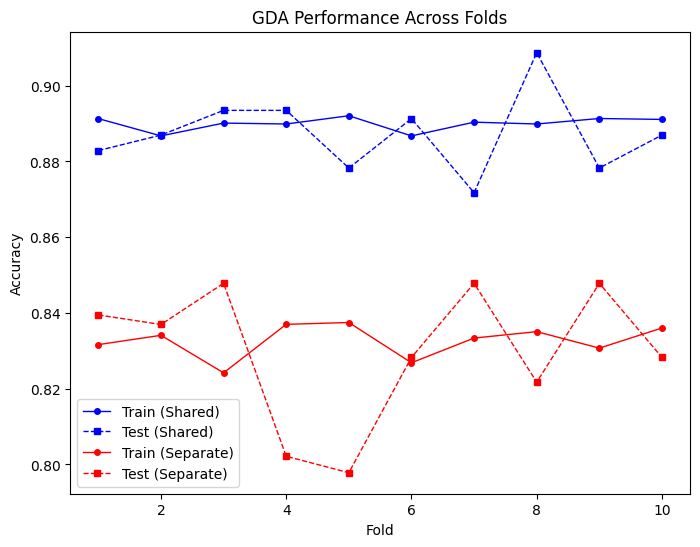

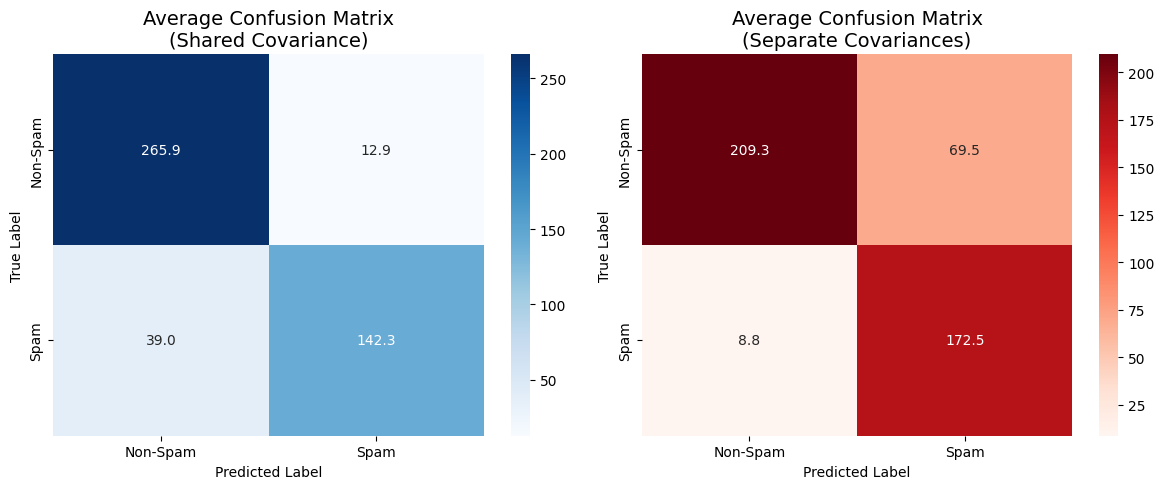

In [10]:
%pip install ucimlrepo

import numpy as np
from ucimlrepo import fetch_ucirepo
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

class GuassianDiscriminantAnalysis():
    def __init__(self, shared_covariance = True):
        self.shared_covariance = shared_covariance
        self.mu0 = None # Mean for class 0
        self.mu1 = None # Mean for class 1
        self.sigma = None # Shared covariance
        self.sigma0 = None # Covariance for class 0
        self.sigma1 = None # Covariance for class 1
        self.pi = None # Prior probablity for class 1

    def fit(self, X, y):
        """
        Fit the GDA model to the data
        X : numpy array of shape (n_samples, n_features)
        y : numpy array of shape (n_samples,)
        """
        x0 = X[y == 0]
        x1 = X[y == 1]

        # Means for each class
        self.mu0 = np.mean(x0, axis=0)
        self.mu1 = np.mean(x1, axis=0)

        # Prior probablity for class 1
        self.pi = np.mean(y == 1)

        if self.shared_covariance:
            # Center the data
            X0_centered = x0 - self.mu0
            X1_centered = x1 - self.mu1

            X_centered = np.vstack([X0_centered, X1_centered])

            # Calculate the shared covariance
            n = X_centered.shape[0]
            # Add small regularization term
            self.sigma = X_centered.T @ X_centered / n + 1e-6 * np.eye(X_centered.shape[1])
        else:
            # Calculate the covariance for each class
            X0_centered = x0 - self.mu0
            n0 = X0_centered.shape[0]
            self.sigma0 = X0_centered.T @ X0_centered / n0 + 1e-6 * np.eye(self.mu0.shape[0])

            X1_centered = x1 - self.mu1
            n1 = X1_centered.shape[0]
            self.sigma1 = X1_centered.T @ X1_centered / n1 + 1e-6 * np.eye(self.mu1.shape[0])

    def predict_proba(self, X):
        """
        Predict the probability of each class for each sample
        X : numpy array of shape (n_samples, n_features)
        Returns : numpy array of shape (n_samples, 2)
        """
        n_samples = X.shape[0]

        if self.shared_covariance:
            log_likelihood0 = multivariate_normal.logpdf(X, mean=self.mu0, cov=self.sigma)
            log_likelihood1 = multivariate_normal.logpdf(X, mean=self.mu1, cov=self.sigma)
        else:
            log_likelihood0 = multivariate_normal.logpdf(X, mean=self.mu0, cov=self.sigma0)
            log_likelihood1 = multivariate_normal.logpdf(X, mean=self.mu1, cov=self.sigma1)

        # Add priors
        log_posterior0 = log_likelihood0 + np.log(1 - self.pi)
        log_posterior1 = log_likelihood1 + np.log(self.pi)

        log_posteriors = np.column_stack([log_posterior0, log_posterior1])
        log_sum = np.logaddexp(log_posterior0, log_posterior1)
        probs = np.exp(log_posteriors - log_sum.reshape(-1, 1))

        return probs

    def predict(self, X):
        """
        Predict the class for each sample
        X : numpy array of shape (n_samples, n_features)
        Returns : numpy array of shape (n_samples,)
        """
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

def fetch_spambase_data():
    """
    Fetch Spambase dataset from UCI repository
    Returns:
    --------
    X : numpy array
        Features
    y : numpy array
        Targets
    """
    spambase = fetch_ucirepo(id=94)
    # Extract features and targets
    X = spambase.data.features.values
    y = spambase.data.targets.values.ravel()
    return X, y

def evaluate_GDA(X, y, shared_covariance = True):
    """
    Evaluate the GDA model on the given data using 10-fold cross validation
    X : numpy array of shape (n_samples, n_features)
    y : numpy array of shape (n_samples,)
    """
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    training_accuracies = []
    test_accuracies = []
    confusion_matrices = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit GDA model
        gda = GuassianDiscriminantAnalysis(shared_covariance=shared_covariance)
        gda.fit(X_train, y_train)

        # Predict
        train_pred = gda.predict(X_train)
        test_pred = gda.predict(X_test)

        # Calculate accuracy
        training_accuracy = accuracy_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, test_pred)

        # Calculate confusion matrix
        confusion_matrix_test = confusion_matrix(y_test, test_pred)

        training_accuracies.append(training_accuracy)
        test_accuracies.append(test_accuracy)
        confusion_matrices.append(confusion_matrix_test)

    return training_accuracies, test_accuracies, confusion_matrices

def main():
    # Fetch data
    X, y = fetch_spambase_data()

    # Standardize data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Evaluate GDA
    shared_training_accuracies, shared_test_accuracies, shared_confusion_matrices = evaluate_GDA(X, y, shared_covariance=True)
    seperate_training_accuracies, seperate_test_accuracies, seperate_confusion_matrices = evaluate_GDA(X, y, shared_covariance=False)

    # Summary
    print("\n" + "=" * 50)
    print("Summary:")
    print("=" * 50 + '\n')
    print("Shared Covariance:")
    print(f"Mean train accuracy: {np.mean(shared_training_accuracies):.4f}")
    print(f"Mean test accuracy: {np.mean(shared_test_accuracies):.4f}")
    print("Seperate Covariance:")
    print(f"Mean train accuracy: {np.mean(seperate_training_accuracies):.4f}")
    print(f"Mean test accuracy: {np.mean(seperate_test_accuracies):.4f}")

    # Visualization
    plt.figure(figsize=(8, 6))
    fold_numbers = np.arange(1, 11)
    plt.plot(fold_numbers, shared_training_accuracies, 'b-o', label='Train (Shared)', linewidth=1.0, markersize=4.0)
    plt.plot(fold_numbers, shared_test_accuracies, 'b--s', label='Test (Shared)', linewidth=1.0, markersize=4.0)
    plt.plot(fold_numbers, seperate_training_accuracies, 'r-o', label='Train (Separate)', linewidth=1.0, markersize=4.0)
    plt.plot(fold_numbers, seperate_test_accuracies, 'r--s', label='Test (Separate)', linewidth=1.0, markersize=4.0)
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('GDA Performance Across Folds')
    plt.legend()
    plt.show()

    # Calculate average confusion matrices
    avg_cm_shared = np.mean(shared_confusion_matrices, axis=0)
    avg_cm_separate = np.mean(seperate_confusion_matrices, axis=0)

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot shared covariance confusion matrix
    sns.heatmap(avg_cm_shared, annot=True, fmt='.1f', cmap='Blues', ax=axes[0],
                xticklabels=['Non-Spam', 'Spam'],
                yticklabels=['Non-Spam', 'Spam'])
    axes[0].set_title('Average Confusion Matrix\n(Shared Covariance)', fontsize=14)
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Plot separate covariance confusion matrix
    sns.heatmap(avg_cm_separate, annot=True, fmt='.1f', cmap='Reds', ax=axes[1],
                xticklabels=['Non-Spam', 'Spam'],
                yticklabels=['Non-Spam', 'Spam'])
    axes[1].set_title('Average Confusion Matrix\n(Separate Covariances)', fontsize=14)
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
